In [1]:
import cv2 
import os 
import glob
import json
import csv
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd


from tqdm import tqdm 
from module.utils import imread, imfindcircles, findProjectiveTransform, str2array, adjust_gamma
from module.disp_measure import displacement_measure

In [6]:
# 센서 번호 입력

sensor_num = str('050')

# 센서 번호에 따른 이미지 리스트 호출
img_list = glob.glob(os.path.join('/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data', '*' + sensor_num + '*.jpg'))

# 센서 번호에 따른 세부 파라메터 호출 
with open('params.json') as param_config_json : 
    param_config = json.load(param_config_json)
    
params = param_config[sensor_num]



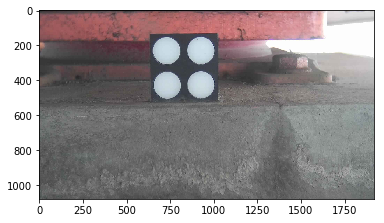

In [2]:
src_img = imread('/home/sss/Desktop/Img_050_20200910_140100.jpg')
plt.imshow(src_img)

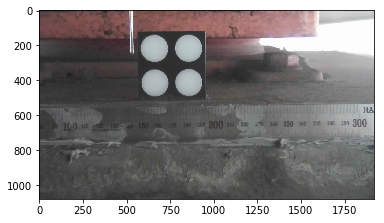

In [4]:
dest_img = imread('/home/sss/Desktop/Img_050_20201027_070100.jpg')
plt.imshow(dest_img)

In [7]:
disp, dest_circles = displacement_measure(dest_img,
                                          src_img,
                                          params = params,
#                                               src_circles = src_circles
                                          )
disp, dest_circles

(array([[17.39223187],
        [27.17155447]]),
 array([[ 853.75,  646.25,   85.  ],
        [ 853.75,  433.75,   85.  ],
        [1066.25,  646.25,   85.  ],
        [1066.25,  433.75,   85.  ]]))

In [3]:
params

{'min_rad': 50,
 'max_rad': 90,
 'sensitivity': 0.98,
 'src_img': 'Img_008_20200901_160100.jpg',
 'gamma': '0.2'}

In [4]:
img_list

['/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Iss_008_20191125_181817.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Iss_008_20191125_185545.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_170100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_180100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_190100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_020100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_030100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_040100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_050100.jpg',
 '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_008_20200917_060100.jpg',


In [5]:
src_img = cv2.imread(img_list[15])

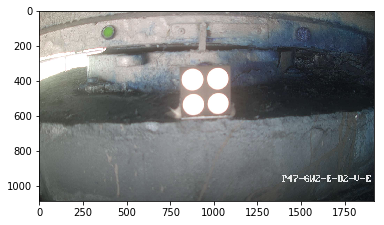

In [6]:
plt.imshow(src_img)

In [7]:
dest_img = cv2.imread(img_list[10])

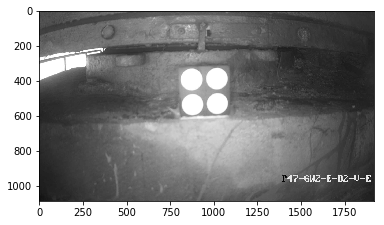

In [8]:
plt.imshow(dest_img)

In [10]:
disp, dest_circles = displacement_measure(dest_img,
                                          src_img,
                                          params = params,
#                                               src_circles = src_circles
                                          )
print(disp)

[[-0.85844702]
 [ 0.00283832]]


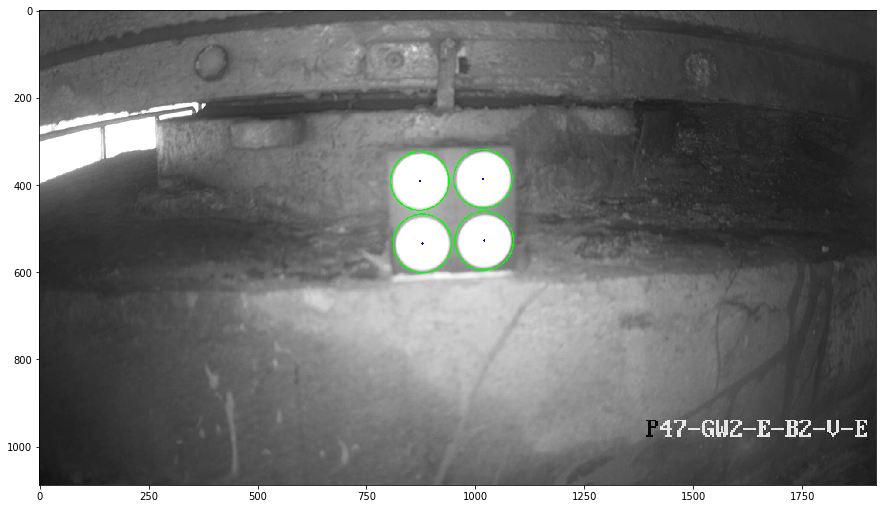

In [11]:
if dest_circles is not None: 
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(dest_circles)) 
    for pt in circles: 
        a, b, r = pt[0], pt[1], pt[2]   
        # Draw the circumference of the circle. 
        cv2.circle(dest_img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(dest_img, (a, b), 1, (0, 0, 255), 3) 
        
    plt.figure(figsize=(15, 15))
    plt.imshow(dest_img) 
else:
    plt.imshow(dest_img)

  0%|          | 0/3 [00:00<?, ?it/s]

70
100
1.0
0.98
0


 33%|███▎      | 1/3 [00:01<00:03,  1.77s/it]

70
100
1.0
0.98
0


 67%|██████▋   | 2/3 [00:03<00:01,  1.90s/it]

70
100
1.0
0.98
0


100%|██████████| 3/3 [00:06<00:00,  2.00s/it]


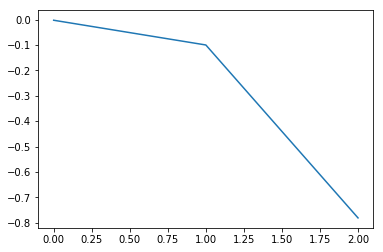

In [10]:
result = [] # 결과를 저장할 result list 

# 최초 source image에서 circle detection 수행 
src_img = cv2.imread(img_list[0])
centers, r_estimated, metric = imfindcircles(src_img, 
                                             [params['min_rad'], params['max_rad']],
                                            sensitivity = 0.97)
src_circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
src_circles = np.squeeze(src_circles)

# 호출된 이미지 목록에서 displacement_measure 수행 
for img_path in tqdm(img_list[:3]): 
    dest_img = cv2.imread(img_path)
    
    '''
    변경사항
    1. 함수 이름을 displacement_measure로 변경하였습니다. 
    2. displacement_measure에 필요한 변수는 아래와 같습니다. 
        1) dest_img : 측정 대상 이미지 
        2) src_img : 고정점 이미지 
        3) src_circles : 고정점 이미지에서 탐지된 원들의 중심 좌표 및 지름 (고정점 이미지에서 변위 재측정 방지용)
        4) min_rad : 최소 원의 지름 크기 / max_rad : 최대 원의 지름 크기 
    '''
    disp, dest_circles = displacement_measure(dest_img,
                                              src_img,
                                              params = params,
                                              src_circles = src_circles
                                              )
    
    result.append(disp)
    for dest_circle in dest_circles : 
        dest_img = cv2.circle(dest_img, tuple(np.asarray(dest_circle[:2], dtype =np.int64)), int(dest_circle[2]), (0,255,0), thickness=1, lineType=8, shift=0)
    cv2.imwrite(img_path[:-4] + '_with_circles_result.jpeg', dest_img)
    
collect_rslt = []
for rslt in result : 
    collect_rslt.append(rslt[0])
    
plt.plot(np.array(collect_rslt))

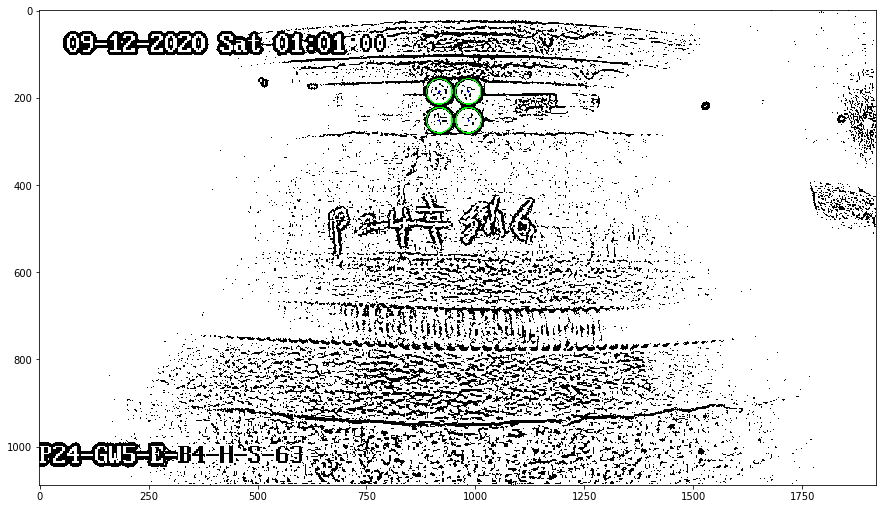

In [63]:
## check the circle detection accuracy 
min_rad = 21
max_rad = 40
img = imread(r'/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_035_20200912_010100.jpg') 
img1 = imread(r'/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/2019/data/Img_035_20200912_010100.jpg') 
# img = imread(r'/home/sss/Desktop/Img_023_20201023_010100.jpg') 

img = adjust_gamma(img, gamma=0.3)

# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# img[:,:,0] = clahe.apply(img[:,:,0])
# img[:,:,1] = clahe.apply(img[:,:,1])
# img[:,:,2] = clahe.apply(img[:,:,2])

img[:,:,0] = cv2.adaptiveThreshold(img[:,:,0],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,min_rad,2)

img[:,:,1] = cv2.adaptiveThreshold(img[:,:,1],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,min_rad,2)

img[:,:,2] = cv2.adaptiveThreshold(img[:,:,2],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,min_rad,2)



centers, r_estimated, metric = imfindcircles(img, 
                                             [min_rad, max_rad],
                                             sensitivity = 0.96)

circles = np.concatenate((centers, r_estimated[:,np.newaxis]), axis = 0).T
circles = np.squeeze(circles)
circles
# circles
# Draw circles that are detected. 
if circles is not None: 
    # Convert the circle parameters a, b and r to integers. 
    circles = np.uint16(np.around(circles)) 
    for pt in circles: 
        a, b, r = pt[0], pt[1], pt[2]   
        # Draw the circumference of the circle. 
        cv2.circle(img, (a, b), r, (0, 255, 0), 2) 
        # Draw a small circle (of radius 1) to show the center. 
        cv2.circle(img, (a, b), 1, (0, 0, 255), 3) 
        
    plt.figure(figsize=(15, 15))
    plt.imshow(img) 
else:
    plt.imshow(img1)
    
    
    

In [316]:
circles

array([[984, 286,  32],
       [984, 218,  32],
       [916, 216,  32],
       [917, 286,  32]], dtype=uint16)